# TA_session_BIPS

Progamming tutorial of paper, "BIPS: Bi-modal Indoor Panorama Synthesis via Residual Depth-aided Adversarial Learning", presented in *ECCV 2022*.

## 0) 드라이브 마운트 & 필요한 라이브러리 임포트

---


In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/KCVS/TA_session')

Mounted at /content/drive


In [ ]:
import math
import random
from tqdm import tqdm

import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import plotly.graph_objects as go

import torch
import torch.nn as nn
import torch.nn.functional as F

from config import config     ## 데이터 로드 및 모델 구축에 사용한 hyper parameter들 저장해놓은 configuration

seed=1
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

### Overall Structure

![overall_all](https://drive.google.com/uc?id=1Y1IV8yRyTpEnQN9vO6UQY4vbPIb0z9Bs)

#### 실습 내용:

* 데이터 로더 (인풋, 아웃풋) 정의

* Mask 정의

* Generator 정의

* FAED score 계산을 위한 Autoencoder 정의

* 테스트 및 Visualization

![overall_dataloader](https://drive.google.com/uc?id=14Cpi8X6sELWez4o8WFcW16mLWSwWstPp)

## 1) 데이터로더 정의

* 인풋: 카메라/LiDAR로 취득한 partial RGBD data
* 아웃풋: 360도 RGBD 이미지

<br>

### 360도 Depth 아웃풋의 경우, room layout (ini)과 residual (res)로 나누어 생성

Depth image = Layout Depth image ($D_{ini}$) + Residual Depth image ($D_{res}$)

![Depths](https://drive.google.com/uc?id=157exxniAi5OxQI_EpzH54UKSP8FjRvGV)


In [ ]:
class dataloader:
    def __init__(self, config):

        print('[*] initializing data loader...')
        self.config = config
        self.root_test = config.test_data_root
        self.batchsize = config.batchsize
        self.imsize = config.imsize
        self.num_workers = 0 
        self.flag_rotate = config.flag_rotate
        self.rotate_val = 0
        self.flag_flip = 0
        if torch.cuda.is_available():
            self.use_cuda = True
            torch.set_default_tensor_type('torch.cuda.FloatTensor')
        else:
            self.use_cuda = False
            torch.set_default_tensor_type('torch.FloatTensor')

        self.input_mode = config.input_mode

        self.RGB_folder_test = self.root_test + "/RGB"
        RGB_list_test = os.listdir(self.RGB_folder_test)
        RGB_list_test.sort()
        self.len_data_test = len(RGB_list_test)
        self.RGB_list_test = RGB_list_test
        
        self.D_folder_test = self.root_test + "/D"
        D_list_test = os.listdir(self.D_folder_test)
        D_list_test.sort()
        len_data_test = len(D_list_test)
        self.D_list_test = D_list_test
        assert len_data_test == self.len_data_test, f"number of images for rgb and depth are different (test): {self.len_data_test} for rgb and {len_data_test} for depth."

        self.D_ini_folder_test = self.root_test + "/D_ini"
        D_ini_list_test = os.listdir(self.D_ini_folder_test)
        D_ini_list_test.sort()
        self.len_data_test = len(D_ini_list_test)
        self.D_ini_list_test = D_ini_list_test
      
        print('[*] data loader initialized.')

    def read_input_test(self, idx):
        rgb_path = self.RGB_folder_test
        rgb_list = self.RGB_list_test
        d_path = self.D_folder_test
        d_list = self.D_list_test
        d_ini_path = self.D_ini_folder_test
        d_ini_list = self.D_ini_list_test

        rgb = torch.zeros(1, 3, self.imsize, 2*self.imsize)
        d = torch.zeros(1, 1, self.imsize, 2*self.imsize)
        d_ini = torch.zeros(1, 1, self.imsize, 2*self.imsize)
        d_res = torch.zeros(self.config.batchsize, 1, self.imsize, 2*self.imsize)

        # color image loading.
        rgb_ = Image.open(rgb_path + "/" + rgb_list[idx], 'r')
        rgb_ = np.asarray(rgb_.resize((2*self.imsize, self.imsize), Image.BILINEAR))

        rgb_ = (rgb_[:,:,:3])

        # transform pixel space into [-1, 1]
        rgb_ = (rgb_/255) * 2 - 1

        # transform into pytorch tensor
        rgb_ = torch.tensor(rgb_).transpose(2,1).transpose(1,0)

        # unsqueeze
        rgb_ =  rgb_.float()
        rgb[0] = rgb_

        # depth image loading.
        
        d_ = Image.open(d_path + "/" + d_list[idx], 'r')
        d_ = np.asarray(d_.resize((2*self.imsize, self.imsize), Image.NEAREST))
        
        d_ini_ = Image.open(d_ini_path + "/" + d_ini_list[idx], 'r')
        d_ini_ = np.asarray(d_ini_.resize((2*self.imsize, self.imsize), Image.NEAREST))

        d_res_ = d_ini_ - d_
        d_res_ = np.where(((d_res_<20)&(d_res_>-20)),0,d_res_)
        d_res_ = np.where(d_res_<-6727,-6727,d_res_)

        d_ = (d_ / (2**16-1)) * self.config.scale_d
            
        d_ini_ = (d_ini_ / (2**16-1)) * self.config.scale_d 
        d_res_ = (d_res_ / (2**16-1)) * self.config.scale_d /1.922 + 5        
        # transform depth space into [0, scale_d] (depth data is in uint16)
       
      
        #transform into pytorch tensor
        d_ = torch.tensor(d_).unsqueeze(0)
        d_ini_ = torch.tensor(d_ini_).unsqueeze(0)
        d_res_ = torch.tensor(d_res_).unsqueeze(0)

        # zero the invalid depth value
        if self.config.flag_zero_invalid_depth:
            d_max_mask = (d_ > 0.85*(self.config.scale_d)).float()
            d_ = d_ * (1-d_max_mask)
        # float
        d_ = d_.float()
        d_ini_ = d_ini_.float()
        d_res_ = d_res_.float()

        d[0] = d_
        d_ini[0] = d_ini_
        d_res[0] = d_res_
        # return
        return rgb, d, d_ini, d_res

    def get_batch_test(self, idx):
        # read input
        rgb_gt, d_gt, d_ini_gt, d_res_gt = self.read_input_test(idx)
        
        if self.use_cuda:
            rgb_gt = rgb_gt.cuda()
            d_gt = d_gt.cuda()
            d_ini_gt = d_ini_gt.cuda()
            d_res_gt = d_res_gt.cuda()
        return rgb_gt, d_gt, d_ini_gt, d_res_gt

    def __len__(self):
        return self.len_data_test

![overall_mask](https://drive.google.com/uc?id=1nwg0hR1Zv9hQbS4NSWx1RMbo6-mVANbp)

## 2) 인풋 데이터 생성을 위한 이미지 마스크 생성

3가지 인풋 시나리오 가정 &rarr; 3가지 상황을 확률적으로 샘플링

>  1. RGB 이미지만 주어지는 경우
>  2. Depth 정보만 주어지는 경우
>  3. RGB와 Depth가 모두 주어지는 경우


RGB 이미지는 **nFoV 카메라**를 통해 얻을 수 있음

Depth 정보는 **nFoV depth 카메라** (Azure Kinect, etc.) 또는 **LiDAR**를 통해 얻을 수 있음 &rarr; 2가지 상황을 확률적으로 샘플링

In [ ]:
def generate_input_mask_batch(config, img_grid):
    mask = generate_input_mask(img_grid).unsqueeze(0)
    for batch in range(1,config.batchsize):
        mask = torch.cat([mask, generate_input_mask(img_grid).unsqueeze(0)], dim=0)
    return mask

def generate_input_mask(img_grid):
    
    # this function generates the final input mask.
    input_mode = random.random() # switch btw RGB, D, RGBD input modes. sample from 0~1 uniform distribution.

    if input_mode < 1/3: # RGB only case
        input_mask = generate_rgb_only_mask(img_grid)
        return input_mask
        
    elif 1/3 <= input_mode < 2/3: # D only case
        d_mode = random.random() # switch btw nfov and lidar modes. sample from 0~1 uniform distribution.
        if d_mode < 1/2: # nfov D case
            input_mask = generate_d_only_nfov_mask(img_grid)
        else: # lidar D case
            input_mask = generate_d_only_lidar_mask(img_grid)
        return input_mask

    else: # RGBD case
        d_mode = random.random() # switch btw nfov and lidar modes. sample from 0~1 uniform distribution.
        if d_mode < 1/2:
            input_mask = generate_rgbd_nfov_mask(img_grid)
        else:
            input_mask = generate_rgbd_lidar_mask(img_grid)
        return input_mask

def generate_rgbd_lidar_mask(img_grid):
    lidar_mask = generate_LIDAR_mask(img_grid)
    nfov_mask = generate_nfov_mask(img_grid)

    nfov_mask = nfov_mask.unsqueeze(0)
    lidar_mask = lidar_mask.unsqueeze(0)
    mask = torch.cat( [nfov_mask, nfov_mask, nfov_mask, lidar_mask], dim=0 )
    return mask

def generate_d_only_lidar_mask(img_grid):
    lidar_mask = generate_LIDAR_mask(img_grid)

    lidar_mask = lidar_mask.unsqueeze(0)
    nfov_mask = torch.zeros_like(lidar_mask)
    mask = torch.cat( [nfov_mask, nfov_mask, nfov_mask, lidar_mask], dim=0 )
    return mask

def generate_rgbd_nfov_mask(img_grid):
    nfov_mask = generate_nfov_mask(img_grid)

    nfov_mask = nfov_mask.unsqueeze(0)
    mask = torch.cat( [nfov_mask, nfov_mask, nfov_mask, nfov_mask], dim=0 )
    return mask

def generate_rgb_only_mask(img_grid):
    nfov_mask = generate_nfov_mask(img_grid)

    nfov_mask = nfov_mask.unsqueeze(0)
    lidar_mask = torch.zeros_like(nfov_mask)
    mask = torch.cat( [nfov_mask, nfov_mask, nfov_mask, lidar_mask], dim=0 )
    return mask

def generate_d_only_nfov_mask(img_grid):
    nfov_mask = generate_nfov_mask(img_grid)

    nfov_mask = nfov_mask.unsqueeze(0)
    rgb_mask = torch.zeros_like(nfov_mask)
    mask = torch.cat( [rgb_mask, rgb_mask, rgb_mask, nfov_mask], dim=0 )
    return mask




> 네트워크 구조는 **ERP** in / **ERP** out 구조로 설계됨

### ERP image 란?

![ERP_image](https://drive.google.com/uc?id=1KUVSnesJLKns9-AWB6Dhhk4_TNJpM4Na)
\( 출처: [paper](https://www.arxiv-vanity.com/papers/1907.11830/) \)

**E**qui**R**ectangular **P**rojection Image (등장방형도법)

* 전방향 카메라 정보를 정규화된 격자 형태로 나타낼 수 있는 이미지 projection 형식

* longitude ($\theta$), latitude ($\phi$)의 격자 이미지로 나타냄

* 익숙한 CNN을 바로 사용 할 수 있는 장점이 있음

* nFoV 이미지는 ERP 상의 <u>빨간색 라인</u>으로 표시된 영역과 같이 Projection 됨

* LiDAR 데이터도 $\theta$, $\phi$ 정보를 사용하여 Projection할 수 있음

<br>

### 설계한 모델 구조 (partial ERP in - full ERP out)

![model_overview](https://drive.google.com/uc?id=1JXFGbn0WRgyUwfJ-PJHC7Y2qCyY0lmgD)

<br>



### Mask 생성 방법

인풋 데이터는 mask simulation을 통해 얻을 수 있음

> Partial 인풋 정보를 ERP 이미지 상에 매핑하는 것 ≃ 전체 ERP 이미지로부터 인풋 영역을 마스킹 하는 것

In [ ]:

def get_global_img_grid(config):
    # mesh grid generation.
    x = np.linspace(-math.pi , math.pi , 2*config.imsize)
    y = np.linspace(math.pi/2 , -math.pi/2 , config.imsize)
    theta, phi = np.meshgrid(x, y)
    theta = torch.tensor(theta).cuda()
    phi = torch.tensor(phi).cuda()

    # get the position along the principal axis(z-axis) on the unit sphere, in erp image coordinate.
    z_erp = torch.cos(phi) * torch.cos(theta)
    x_erp = torch.cos(phi) * torch.sin(theta)
    y_erp = torch.sin(phi)

    return [theta, phi, x_erp, y_erp, z_erp]

def generate_nfov_mask(img_grid):
    # this function generates mask of nfov images of multiple cams on the ERP image grid using pitch angle.
    # in current implementation, the yaw angles between the cameras are set to have the same angular intervals.
    # this function takes approximately 1ms using torch cuda tensor operations.
    
    hor_fov = float(random.randint(60,90))
    ver_fov = float(random.randint(60,90))
    pitch = float(random.randint(-90, 90))
    n_cam = random.randint(1,int(max(min((90/(abs(pitch)+1e-9)),4),1))) # n_cam is adaptive to pitch angle (if pitch=90, n_cam is always 1.)
    flip = random.random()

    assert hor_fov >=0 and ver_fov >= 0 and hor_fov <= 180 and ver_fov <= 180, "fov of nvof image should be in [0, 180]."
    assert -90 <= pitch <= 90, "pitch angle should lie in [-90,90]."

    theta = img_grid[0]
    phi = img_grid[1]
    x_erp = img_grid[2]
    y_erp = img_grid[3]
    z_erp = img_grid[4]

    pitch = pitch * math.pi / 180
    yaw = math.pi * 2 / n_cam

    # max x and y value in the NFoV image plane.  
    max_y = math.tan( (ver_fov+2*pitch)*math.pi/(2*180))
    max_x = math.tan( hor_fov*math.pi/(2*180))
    min_y = math.tan( (-ver_fov+2*pitch)*math.pi/(2*180))
    min_x = math.tan( -hor_fov*math.pi/(2*180))

    # tilt the coordinate along x-axis using the pitch angle to get the nfov image coordinate.
    x_nfov = x_erp
    z_nfov = z_erp*math.cos(pitch) + y_erp*math.sin(pitch)
    y_nfov = -z_erp*math.sin(pitch) + y_erp*math.cos(pitch)

    mask = torch.zeros_like(phi) # initializing mask var.

    for cam in range(n_cam):
        # tilt the coordinate along y-axis using the pitch angle to get the nfov image coordinate.
        tilt_angle = yaw * cam

        y_nfov_ = y_nfov
        z_nfov_ = z_nfov*math.cos(tilt_angle) + x_nfov*math.sin(tilt_angle)
        x_nfov_ = -z_nfov*math.sin(tilt_angle) + x_nfov*math.cos(tilt_angle)

        # shoot the ray until z_nfov=1. We set the NFoV image plane is z_nfov=1 plane. (in other words, z axis is the principal axis)
        y = y_nfov_ / (z_nfov_ + 1e-9)
        x = x_nfov_ / (z_nfov_ + 1e-9)
        z = z_nfov_
        
        # masking the values that have appropriate FoV with positive z_nfov position.
        mask += (y > min_y) * (y < max_y) * (x > min_x) * (x < max_x) * (z >= 0)

    if flip < 1/2:
        mask = torch.flip(mask, [1])
    mask = mask > 0
    
    return torch.tensor(mask).float()

def generate_LIDAR_mask(img_grid): 
    theta = img_grid[0]
    phi = img_grid[1]
    x_erp = img_grid[2]
    y_erp = img_grid[3]
    z_erp = img_grid[4]

    channel = 2 ** random.randint(1,4)
    vert_fov_down = float(random.randint(1, 3) * channel )
    vert_fov_up = float(random.randint(1, 3) * channel )
    pitch = float(random.randint(-90, 90))
    yaw = random.randint(0,360)

    vert_fov_down = (-vert_fov_down) * math.pi / 180  # convert: degree -> radian [pi/2, -pi/2]
    vert_fov_up = (vert_fov_up) * math.pi / 180 # convert: degree -> radian [pi/2, -pi/2]
    pitch = pitch * math.pi / 180 # in radian
    yaw = int(yaw * img_grid[0].shape[1] / 360) # in pixel.

    # tilt the coordinate along x-axis using the pitch angle to get the lidar.
    x_lidar = x_erp
    z_lidar = z_erp*math.cos(pitch) + y_erp*math.sin(pitch)
    y_lidar = -z_erp*math.sin(pitch) + y_erp*math.cos(pitch)

    # sample lidar points using y value.
    vert_interval = (vert_fov_up - vert_fov_down) / channel

    mask = torch.zeros_like(phi)
    margin = math.pi / (phi.shape[0]) # margin is a hyper-parameter.
    for c in range(channel):
        angle = vert_fov_up - c * vert_interval
        mask += ((angle - margin < y_lidar) * (y_lidar < angle + margin) )

    mask = torch.roll(mask, yaw, dims=1)
    mask = mask > 0

    return torch.tensor(mask).float()

### 랜덤 마스크 생성 예시

<ipython-input-5-dee23cb3fd47>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(mask).float()
<ipython-input-5-dee23cb3fd47>:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(mask).float()


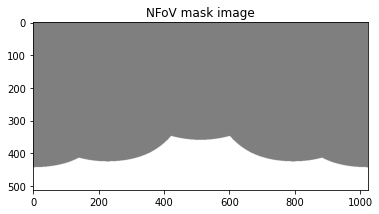

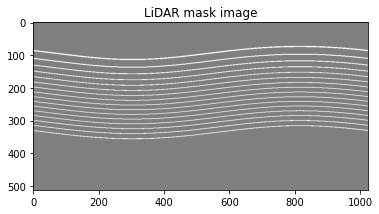

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img_grid = get_global_img_grid(config)

rgb_out = generate_nfov_mask(img_grid)
rgb_out = rgb_out.unsqueeze(0).unsqueeze(0)
rgb_out = torch.cat([rgb_out, rgb_out, rgb_out], dim=1)

depth_out = generate_LIDAR_mask(img_grid)
depth_out = depth_out.unsqueeze(0).unsqueeze(0)
depth_out = torch.cat([depth_out,depth_out,depth_out], dim=1)

outr = np.array(rgb_out.cpu().transpose(1,2).transpose(3,2)) # Batch, Height, Width, Channel
img_r = (255*(outr+1)/2).astype(np.uint8)[0]
imr = Image.fromarray(img_r)

outd = np.array(depth_out.cpu().transpose(1,2).transpose(3,2)) # Batch, Height, Width, Channel
img_d = (255*(outd+1)/2).astype(np.uint8)[0]
imd = Image.fromarray(img_d)

plt.figure()
plt.title('NFoV mask image')
plt.imshow(imr)
plt.show()

plt.figure()
plt.title('LiDAR mask image')
plt.imshow(imd)
plt.show()

plt.close()
del img_grid, rgb_out, depth_out, outr, img_r, imr, outd, img_d, imd

![model_overview](https://drive.google.com/uc?id=14yJ3BuwuxUNUXT0FVq7eV0bKXWw9pFyq)


## 3) 네트워크 정의 - Main model



### Custom layer 정의

In [ ]:
from torch.autograd import Variable
from torch.nn.init import kaiming_normal, xavier_normal, calculate_gain

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

class pixelwise_norm_layer(nn.Module):
    def __init__(self):
        super(pixelwise_norm_layer, self).__init__()
        self.eps = 1e-8

    def forward(self, x):
        return x / (torch.mean(x**2, dim=1, keepdim=True) + self.eps) ** 0.5

class equalized_linear(nn.Module):
    def __init__(self, c_in, c_out, initializer='kaiming'):
        super(equalized_linear, self).__init__()
        self.linear = nn.Linear(c_in, c_out, bias=False)
        if initializer == 'kaiming':    kaiming_normal(self.linear.weight, a=calculate_gain('linear'))
        elif initializer == 'xavier':   torch.nn.init.xavier_normal(self.linear.weight)
        
        linear_w = self.linear.weight.data.clone()
        self.bias = torch.nn.Parameter(torch.FloatTensor(c_out).fill_(0))
        self.scale = (torch.mean(self.linear.weight.data ** 2)) ** 0.5
        self.linear.weight.data.copy_(self.linear.weight.data/self.scale)
        
    def forward(self, x):
        x = self.linear(x.mul(self.scale))
        return x + self.bias.view(1,-1).expand_as(x)

# ref: https://github.com/github-pengge/PyTorch-progressive_growing_of_gans/blob/master/models/base_model.py
class generalized_drop_out(nn.Module):
    def __init__(self, mode='mul', strength=0.4, axes=(0,1), normalize=False):
        super(generalized_drop_out, self).__init__()
        self.mode = mode.lower()
        assert self.mode in ['mul', 'drop', 'prop'], 'Invalid GDropLayer mode'%mode
        self.strength = strength
        self.axes = [axes] if isinstance(axes, int) else list(axes)
        self.normalize = normalize
        self.gain = None

    def forward(self, x, deterministic=False):
        if deterministic or not self.strength:
            return x

        rnd_shape = [s if axis in self.axes else 1 for axis, s in enumerate(x.size())]  # [x.size(axis) for axis in self.axes]
        if self.mode == 'drop':
            p = 1 - self.strength
            rnd = np.random.binomial(1, p=p, size=rnd_shape) / p
        elif self.mode == 'mul':
            rnd = (1 + self.strength) ** np.random.normal(size=rnd_shape)
        else:
            coef = self.strength * x.size(1) ** 0.5
            rnd = np.random.normal(size=rnd_shape) * coef + 1

        if self.normalize:
            rnd = rnd / np.linalg.norm(rnd, keepdims=True)
        rnd = Variable(torch.from_numpy(rnd).type(x.data.type()))
        if x.is_cuda:
            rnd = rnd.cuda()
        return x * rnd

    def __repr__(self):
        param_str = '(mode = %s, strength = %s, axes = %s, normalize = %s)' % (self.mode, self.strength, self.axes, self.normalize)
        return self.__class__.__name__ + param_str

class ERP_padding(nn.Module):
    def __init__(self, pad):
        super(ERP_padding, self).__init__()
        self.pad = pad
    def forward(self, x):
        #x = torch.nn.functional.pad(x, (0, 0, self.pad, self.pad), 'constant', 0)
        #x = torch.nn.functional.pad(x, (self.pad, self.pad, 0, 0), 'circular')
        if self.pad == 0:
            return x
        x = torch.nn.functional.pad(x, (self.pad, self.pad, self.pad, self.pad), 'constant', 0)        
        x[:,:,:,0:self.pad] = x[:,:,:,-2*self.pad:-self.pad]
        x[:,:,:,-self.pad:] = x[:,:,:,self.pad:2*self.pad]
        
        return x

# for equaliaeed-learning rate.
class equalized_conv2d(nn.Module):
    #def __init__(self, c_in, c_out, k_size, stride, pad, initializer='kaiming', bias=False):
    def __init__(self, c_in, c_out, k_size, stride, pad, initializer=None, bias=False):
        super(equalized_conv2d, self).__init__()
        self.conv = nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False)
        if initializer == 'kaiming':    kaiming_normal(self.conv.weight, a=calculate_gain('conv2d'))
        elif initializer == 'xavier':   xavier_normal(self.conv.weight)
        
        #conv_w = self.conv.weight.data.clone()
        self.bias = torch.nn.Parameter(torch.FloatTensor(c_out).fill_(0))
        fan_in = c_in*k_size*k_size
        self.scale = 2/np.sqrt(fan_in)
        #self.scale = (torch.mean(self.conv.weight.data ** 2)) ** 0.5
        self.conv.weight.data.copy_(self.conv.weight.data/self.scale)

    def forward(self, x):
        x = self.conv(x*self.scale)
        return x + self.bias.view(1,-1,1,1).expand_as(x)

class equalized_linear(nn.Module):
    def __init__(self, c_in, c_out, initializer='kaiming'):
        super(equalized_linear, self).__init__()
        self.linear = nn.Linear(c_in, c_out, bias=False)
        if initializer == 'kaiming':    kaiming_normal(self.linear.weight, a=calculate_gain('linear'))
        elif initializer == 'xavier':   torch.nn.init.xavier_normal(self.linear.weight)
        
        linear_w = self.linear.weight.data.clone()
        self.bias = torch.nn.Parameter(torch.FloatTensor(c_out).fill_(0))
        self.scale = (torch.mean(self.linear.weight.data ** 2)) ** 0.5
        self.linear.weight.data.copy_(self.linear.weight.data/self.scale)
        
    def forward(self, x):
        x = self.linear(x.mul(self.scale))
        return x + self.bias.view(1,-1).expand_as(x)

def conv(layers, c_in, c_out, k_size, stride=1, pad=0, leaky=True, bn=False, In=False, wn=False, pixel=False, gdrop=True, circular=True, only=False):
    if circular:
        layers.append( ERP_padding(pad) )
        pad = 0

    if gdrop:       layers.append(generalized_drop_out(mode='prop', strength=0.0))
    if wn:          layers.append(equalized_conv2d(c_in, c_out, k_size, stride, pad, initializer='kaiming'))
    else:           layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad))
    if not only:
        if leaky:   layers.append(nn.LeakyReLU(0.2))
        else:       layers.append(nn.ReLU())
        if bn:      layers.append(nn.BatchNorm2d(c_out))
        if In:      layers.append(nn.InstanceNorm2d(c_out))
        if pixel:   layers.append(pixelwise_norm_layer())
    return layers

def linear(layers, c_in, c_out, sig=True, wn=False):
    layers.append(Flatten())
    if wn:      layers.append(equalized_linear(c_in, c_out, initializer='kaiming'))
    else:       layers.append(nn.Linear(c_in, c_out)) 
    if sig:     layers.append(nn.Sigmoid())
    return layers
    

def get_module_names(model):
    names = []
    for key, val in model.state_dict().items():
        name = key.split('.')[0]
        if not name in names:
            names.append(name)
    return names


def conv_layer(c_in, c_out, k_size, stride=1, pad=0, leaky=False, norm=False, circular=True):
    layers = []
    if circular:
        layers.append( ERP_padding(pad) )
        pad = 0 
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad))
    #layers.append(equalized_conv2d(c_in, c_out, k_size, stride, pad))
    if norm:    layers.append(nn.InstanceNorm2d(c_out))    
    else:       pass
    if leaky:   layers.append(nn.LeakyReLU(0.2))
    else:       layers.append(nn.ReLU())
    return nn.Sequential( *layers )

def conv(layers, c_in, c_out, k_size, stride=1, pad=0, leaky=True, bn=False, In=False, wn=False, pixel=False, gdrop=True, circular=True, only=False):
    if circular:
        layers.append( ERP_padding(pad) )
        pad = 0

    if gdrop:       layers.append(generalized_drop_out(mode='prop', strength=0.0))
    if wn:          layers.append(equalized_conv2d(c_in, c_out, k_size, stride, pad, initializer='kaiming'))
    else:           layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad))
    if not only:
        if leaky:   layers.append(nn.LeakyReLU(0.2))
        else:       layers.append(nn.ReLU())
        if bn:      layers.append(nn.BatchNorm2d(c_out))
        if In:      layers.append(nn.InstanceNorm2d(c_out))
        if pixel:   layers.append(pixelwise_norm_layer())
    return layers

def linear(layers, c_in, c_out, sig=True, wn=False):
    layers.append(Flatten())
    if wn:      layers.append(equalized_linear(c_in, c_out, initializer='kaiming'))
    else:       layers.append(nn.Linear(c_in, c_out)) 
    if sig:     layers.append(nn.Sigmoid())
    return layers
    

def get_module_names(model):
    names = []
    for key, val in model.state_dict().items():
        name = key.split('.')[0]
        if not name in names:
            names.append(name)
    return names



### Generator 정의

본 tutorial 에서는 training을 수행하지 않기 때문에 Discriminator는 사용하지 않음


#### Generator 구조
![generator_str](https://drive.google.com/uc?id=1GcF05QdwyR6F1XmdehZjp1MdPi4sLrK_)

크게 보면, Input Branch - Downsample Block - Mid Block - Upsample Block - Output Branch 로 이루어짐

* Input Branch: Partial RGB/D 인풋을 두개의 branch가 encode
* Downsample Block: Feature size를 줄이면서 global 정보를 encode
* Mid Block: Feature size를 동일하게 유지하면서 encode
* Upsample Block: Feature size를 증가시키면서 이미지 decode
* Output Branch: Full RGB, Depth-layout (ini), Depth-residual (res)를 세개의 branch에서 decode

<br>

* Downsample, Mid, Upsample branch에서 1) RGB-D feature간의 정보 교환, 2) Residual connection 존재
  * 1) 다른 mode에서 촬영된 정보로부터 이미지를 추론할 수 있도록 함
  * 2) Detail한 정보를 복원할 수 있도록 함



In [ ]:
class Generator(nn.Module):
    def __init__(self, config):
        super(Generator, self).__init__()
        self.config = config
        self.flag_bn = config.flag_bn
        self.flag_in = config.flag_in
        self.flag_pixelwise = config.flag_pixelwise
        self.flag_wn = config.flag_wn
        self.flag_leaky = config.flag_leaky
        self.flag_tanh = config.flag_tanh
        self.flag_sigmoid_depth = config.flag_sigmoid_depth
        self.flag_norm_latent = config.flag_norm_latent
        self.nc = len(config.input_mode)
        self.outnc = config.outnc
        self.ngf = config.ngf
        self.max_ngf = config.max_ngf
        self.min_ngf = self.ngf
        self.circular = config.flag_circular_pad

        # input branches.
        self.input_rgb = self.input_branch(3)
        if "DL" in self.config.input_mode:
            self.input_d = self.input_branch(2)
        elif "L" in self.config.input_mode or "D" in self.config.input_mode:
            self.input_d = self.input_branch(1)

        # fused data processing layer: U-Net based network.
        self.down1 = self.downsample_block(64)
        self.down1_d = self.downsample_block(64)

        self.down2 = self.downsample_same_block(128)
        self.down2_d = self.downsample_same_block(128)

        self.down3 = self.downsample_same_block(256)
        self.down3_d = self.downsample_same_block(256)

        self.down4 = self.downsample_same_block(256)
        self.down4_d = self.downsample_same_block(256)

        self.mid = self.mid_block(512)
        self.mid_d = self.mid_block(512)

        self.up4 = self.upsample_block(512)
        self.up4_d = self.upsample_block(512)

        self.up3 = self.upsample_block(256)
        self.up3_d = self.upsample_block(256)


        self.up2 = self.upsample_block(256)
        self.up2_d = self.upsample_block(256)

        self.up1 = self.upsample_block(128)
        self.up1_d = self.upsample_block(128)


        # output branches.
        self.output_rgb = self.output_block(3)
        self.output_d_res= self.output_block(1)
        self.output_d_ini = self.output_block(1)

    def input_branch(self, nc):
        layers = []
        ndim = self.ngf
##여기
        layers = conv(layers, nc, ndim, 7, 1, 3, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)

        # downsample once.
        if "L" in self.config.input_mode or "D" in self.config.input_mode:
            ndim = min(self.max_ngf, self.ngf * 2)
            layers = conv(layers, ndim//2, ndim, 4, 2, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        else:
            ndim = min(self.max_ngf, self.ngf * 4)
            layers = conv(layers, ndim//4, ndim, 4, 2, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        
        return  nn.Sequential(*layers)



    def downsample_block(self,ngf):
        
        ndim = min(self.max_ngf, ngf * 2)

        layers = []
        #layers.append(nn.Upsample(scale_factor=2, mode='nearest'))       # scale up by factor of 2.0
        
        layers = conv(layers, ngf, ndim, 4, 2, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)

        
        return  nn.Sequential(*layers)
    
    def downsample_same_block(self, ndim):
        

        layers = []
        #layers.append(nn.Upsample(scale_factor=2, mode='nearest'))       # scale up by factor of 2.0
        
        layers = conv(layers, ndim, ndim, 4, 2, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)

        self.ngf = self.ngf * 2
        
        return  nn.Sequential(*layers)
        

    def mid_block(self,ndim):
        
        layers = []
        
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim//2, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        return  nn.Sequential(*layers)

    def upsample_block(self,ngf):
        
        ndim = ngf//2

        layers = []
        layers.append(nn.Upsample(scale_factor=2, mode='bilinear'))       # scale up by factor of 2.0
        
        layers = conv(layers, ngf, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)

        
        return  nn.Sequential(*layers)

    def upsample_same_block(self,ndim):
        
        layers = []
        layers.append(nn.Upsample(scale_factor=2, mode='bilinear'))       # scale up by factor of 2.0
        
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)

        
        return  nn.Sequential(*layers)

    def output_block(self, outnc):

        ndim = 32

        layers = []
        # upsample once.
        layers.append(nn.Upsample(scale_factor=2, mode='bilinear'))       # scale up by factor of 2.0
        layers = conv(layers, 64, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)

        # map to the target domain.
        layers = conv(layers, ndim, outnc, 1, 1, 0, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, only=True, circular=self.circular)
        
        return nn.Sequential(*layers)

    def freeze_layers(self):
        # let's freeze pretrained blocks. (Found freezing layers not helpful, so did not use this func.)
        print('freeze pretrained weights ... ')
        for param in self.model.parameters():
            param.requires_grad = False

    def forward(self, x):
        #x_ = self.first_layer(x)
        rgb = x[:,:3]
        rgb = self.input_rgb(rgb)
        
        if "D" in self.config.input_mode or "L" in self.config.input_mode:
            d = x[:,3:]
            d = self.input_d(d)

        x1 = self.down1(rgb)
        x1_d = self.down1_d(d)

        x2 = self.down2(x1)
        x2_d = self.down2_d(x1_d)
        
        x2_cat = torch.cat( [x2, x2_d], dim=1 )

        x3 = self.down3(x2_cat)
        x3_d = self.down3_d(x2_cat)
        
        x4 = self.down4(x3)
        x4_d = self.down4_d(x3_d)
            
        x_ = torch.cat( [x4, x4_d], dim=1 )

        xm_ = self.mid(x_)
        xm_d = self.mid_d(x_)

        xm_cat = torch.cat( [xm_, xm_d], dim=1 )

        x4_ = self.up4(xm_cat + x_)
        x4_d_ = self.up4_d(xm_cat + x_)
        
        x3_ = self.up3(x4_ + x3)
        x3_d_ = self.up3_d(x4_d_ + x3_d)

        x3_cat = torch.cat( [x3_, x3_d_], dim=1 )

        x2_ = self.up2(x3_cat + x2_cat)
        x2_d_ = self.up2_d(x3_cat + x2_cat)

        x1_ = self.up1(x2_ + x1)
        x1_d_ = self.up1_d(x2_d_ + x1_d)


        d_res = self.output_d_res(x1_d_ + d)
        d_ini = self.output_d_ini(x1_d_ + d)
        rgb = self.output_rgb(x1_ + rgb)

        
        rgb = torch.tanh(rgb)
        
        d_res = torch.sigmoid(d_res) * self.config.scale_d / 9.362
        d_ini= torch.sigmoid(d_ini) * self.config.scale_d / 9.362
        
        
        out = torch.cat([rgb,d_ini,d_res], dim=1)
     

        return out


![overall_faed](https://drive.google.com/uc?id=1BoSnrZ8eRRQq-gQsA9sXZxuToUZj7F7d)

## 4) 네트워크 정의 - FAED score 계산을 위한 Autoencoder 정의




### Custom layer 정의 

In [ ]:
class CircularPadding(nn.Module):
    def __init__(self, pad):
        super(CircularPadding, self).__init__()
        self.pad = pad
    def forward(self, x):
        if self.pad == 0:
            return x
        x = torch.nn.functional.pad(x, (self.pad, self.pad, self.pad, self.pad), 'constant', 0)        
        x[:,:,:,0:self.pad] = x[:,:,:,-2*self.pad:-self.pad]
        x[:,:,:,-self.pad:] = x[:,:,:,self.pad:2*self.pad]
        return x

class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(Conv2d, self).__init__()
        self.pad = CircularPadding(padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=0)

    def forward(self, x):
        x = self.conv2d( self.pad (x) )
        return x

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super(ResBlock,self).__init__()
        
        self.relu = nn.ReLU()

        self.conv1 = Conv2d(in_channels, out_channels, kernel_size, stride = 1, padding = padding )
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = Conv2d(out_channels, out_channels, kernel_size, stride = 1, padding = padding )
        self.batchnorm2 = nn.BatchNorm2d(out_channels)
    
    def forward(self,x):

        out = self.relu( self.batchnorm1( self.conv1(x) ) )
        out = self.batchnorm2( self.conv2(out) )    
        out += x    

        return out 

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding ):
        super(ConvBlock,self).__init__()

        self.relu = nn.ReLU()

        self.conv1 = Conv2d(in_channels, out_channels, kernel_size, stride, padding )
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):

        x = self.relu( self.batchnorm1( self.conv1( x )))

        return x 



#### Autoencoder 구조

![autoencoder](https://drive.google.com/uc?id=1piyF6REAPTuixWFJFvMJnhzTM_D2Ogrp)

Downsample 하는 Encoder - Upsampling 하는 Decoder로 구성됨

Encoder의 결과물로 얻어진 feature를 FAED score 계산에 사용


In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.upsampling = nn.functional.interpolate

        self.upconv1 = ConvBlock(in_channels = 256, out_channels = 128, kernel_size = 3, stride = 1, padding = 1) # 이건 안 쓰인다.

        self.channelAttnetion_rgb = torch.nn.Parameter(torch.randn(128,1,1)) # 이건 안 쓰인다.
        self.channelAttnetion_d = torch.nn.Parameter(torch.randn(128,1,1)) # 이건 안 쓰인다.

        self.upconv2_rgb = ConvBlock(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1, padding = 1) 
        self.upconv3_rgb = ConvBlock(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1, padding = 1) 
        self.upconv4_rgb = ConvBlock(in_channels = 128, out_channels = 64, kernel_size = 3, stride = 1, padding = 1) 
        self.upconv5_rgb = ConvBlock(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1, padding = 1) 

        self.upconv2_d = ConvBlock(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1, padding = 1) 
        self.upconv3_d = ConvBlock(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1, padding = 1) 
        self.upconv4_d = ConvBlock(in_channels = 128, out_channels = 64, kernel_size = 3, stride = 1, padding = 1) 
        self.upconv5_d = ConvBlock(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1, padding = 1) 

        self.outconv_rgb = Conv2d(in_channels = 32, out_channels = 3 , kernel_size = 9, stride = 1, padding = 4) 
        self.outconv_d = Conv2d(in_channels = 32, out_channels = 1 , kernel_size = 9, stride = 1, padding = 4) 

        self.upres2_rgb = ResBlock(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1)
        self.upres3_rgb = ResBlock(in_channels = 128, out_channels = 128, kernel_size = 5, padding = 2) 
        self.upres4_rgb = ResBlock(in_channels = 64, out_channels = 64, kernel_size = 7, padding = 3) 
        self.upres5_rgb = ResBlock(in_channels = 32, out_channels = 32, kernel_size = 9, padding = 4) 
        
        self.upres2_d = ResBlock(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1)
        self.upres3_d = ResBlock(in_channels = 128, out_channels = 128, kernel_size = 5, padding = 2) 
        self.upres4_d = ResBlock(in_channels = 64, out_channels = 64, kernel_size = 7, padding = 3) 
        self.upres5_d = ResBlock(in_channels = 32, out_channels = 32, kernel_size = 9, padding = 4) 

    def forward(self, x):

        #x = self.upconv1(x)
        x = self.upsampling(x, scale_factor = 2 ,mode = 'bilinear', align_corners = False)    
        rgb = x[:,:128]    
        d = x[:,128:]

        #rgb = torch.sigmoid(self.channelAttnetion_rgb).expand_as(x) * x
        #rgb = self.upconv2_rgb(x)
        rgb = self.upconv2_rgb(rgb)
        rgb = self.upres2_rgb(rgb)
        rgb = self.upsampling(rgb, scale_factor = 2 ,mode = 'bilinear', align_corners = False)
        rgb = self.upconv3_rgb(rgb)
        rgb = self.upres3_rgb(rgb)
        rgb = self.upsampling(rgb, scale_factor = 2 ,mode = 'bilinear', align_corners = False)
        rgb = self.upconv4_rgb(rgb)
        rgb = self.upres4_rgb(rgb)
        rgb = self.upsampling(rgb, scale_factor = 2 ,mode = 'bilinear', align_corners = False)
        rgb = self.upconv5_rgb(rgb)
        rgb = self.upres5_rgb(rgb)
        rgb = self.upsampling(rgb, scale_factor = 2 ,mode = 'bilinear', align_corners = False)
        rgb = self.outconv_rgb(rgb)

        #d = torch.sigmoid(self.channelAttnetion_d).expand_as(x) * x
        #d = self.upconv2_d(x)
        d = self.upconv2_d(d)
        d = self.upres2_d(d)
        d = self.upsampling(d, scale_factor = 2 ,mode = 'bilinear', align_corners = False)
        d = self.upconv3_d(d)
        d = self.upres3_d(d)
        d = self.upsampling(d, scale_factor = 2 ,mode = 'bilinear', align_corners = False)
        d = self.upconv4_d(d)
        d = self.upres4_d(d)
        d = self.upsampling(d, scale_factor = 2 ,mode = 'bilinear', align_corners = False)
        d = self.upconv5_d(d)
        d = self.upres5_d(d)
        d = self.upsampling(d, scale_factor = 2 ,mode = 'bilinear', align_corners = False)
        d = self.outconv_d(d)

        x = torch.cat([rgb,d],dim=1)
        return x

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.downconv1_rgb = Conv2d(in_channels = 3, out_channels = 32, kernel_size = 9, stride = 1, padding = 4)
        self.downconv1_d = Conv2d(in_channels = 1, out_channels = 32, kernel_size = 9, stride = 1, padding = 4)
        
        self.downconv2_rgb = ConvBlock(in_channels = 32, out_channels = 64, kernel_size = 4, stride = 2, padding = 1) 
        self.downconv2_d = ConvBlock(in_channels = 32, out_channels = 64, kernel_size = 4, stride = 2, padding = 1) 

        self.downconv3_rgb = ConvBlock(in_channels = 64, out_channels = 128, kernel_size = 4, stride = 2, padding = 1)
        self.downconv3_d = ConvBlock(in_channels = 64, out_channels = 128, kernel_size = 4, stride = 2, padding = 1)

        self.downconv4_rgb = ConvBlock(in_channels = 128, out_channels = 128, kernel_size = 4, stride = 2, padding = 1)
        self.downconv4_d = ConvBlock(in_channels = 128, out_channels = 128, kernel_size = 4, stride = 2, padding = 1)

        self.downconv5_rgb = ConvBlock(in_channels = 128, out_channels = 128, kernel_size = 4, stride = 2, padding = 1)
        self.downconv5_d = ConvBlock(in_channels = 128, out_channels = 128, kernel_size = 4, stride = 2, padding = 1)

        self.downconv6_rgb = ConvBlock(in_channels = 128, out_channels = 128, kernel_size = 4, stride = 2, padding = 1)
        self.downconv6_d = ConvBlock(in_channels = 128, out_channels = 128, kernel_size = 4, stride = 2, padding = 1)

        self.downres1_rgb = ResBlock(in_channels = 32, out_channels = 32, kernel_size = 9, padding = 4)
        self.downres1_d = ResBlock(in_channels = 32, out_channels = 32, kernel_size = 9, padding = 4)

        self.downres2_rgb = ResBlock(in_channels = 64, out_channels = 64, kernel_size = 7, padding = 3)
        self.downres2_d = ResBlock(in_channels = 64, out_channels = 64, kernel_size = 7, padding = 3)

        self.downres3_rgb = ResBlock(in_channels = 128, out_channels = 128, kernel_size = 5, padding = 2)
        self.downres3_d = ResBlock(in_channels = 128, out_channels = 128, kernel_size = 5, padding = 2)

        self.downres4_rgb = ResBlock(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1)
        self.downres4_d = ResBlock(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1)

        self.downres5_rgb = ResBlock(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1)
        self.downres5_d = ResBlock(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1)

        self.fuse = Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1, padding = 1) 

    def forward(self, x):
        rgb = x[:,:3]
        rgb = self.downconv1_rgb(rgb)
        rgb = self.downres1_rgb(rgb)
        rgb = self.downconv2_rgb(rgb)
        rgb = self.downres2_rgb(rgb)
        rgb = self.downconv3_rgb(rgb)
        rgb = self.downres3_rgb(rgb)
        rgb = self.downconv4_rgb(rgb)
        rgb = self.downres4_rgb(rgb)
        rgb = self.downconv5_rgb(rgb)
        rgb = self.downres5_rgb(rgb)
        rgb = self.downconv6_rgb(rgb)

        d = x[:,3:]
        d = self.downconv1_d(d)
        d = self.downres1_d(d)
        d = self.downconv2_d(d)
        d = self.downres2_d(d)
        d = self.downconv3_d(d)
        d = self.downres3_d(d)
        d = self.downconv4_d(d)
        d = self.downres4_d(d)
        d = self.downconv5_d(d)
        d = self.downres5_d(d)
        d = self.downconv6_d(d)

        x1 = torch.cat([rgb,d], dim=1)

        x = self.fuse(x1)

        return x ,x1

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        x, _ = self.encoder(x)
        x = self.decoder(x)
        return x

## 5) 테스트 함수 정의 - 인풋으로부터 이미지 생성

In [ ]:
flag_stat = True

def get_activation(x, net, config):

    x,_ = net(x)

    mean_feature = torch.mean( x, dim = 3, dtype = float )

    weight = torch.cos( torch.linspace(math.pi/2 , -math.pi/2 , mean_feature.shape[-1]) ).unsqueeze(0).unsqueeze(0).expand_as(mean_feature)
    mean_feature = weight * mean_feature

    mean_vector = mean_feature.view( -1, config.feature_size )
    
    return mean_vector

class tester:
    def __init__(self, config):
        self.config = config
        self.config.batchsize = 1
        
        self.global_img_grid = get_global_img_grid(config)
        
        # load trained model.
        
        self.G = Generator(config)
        checkpoint_path = config.G_checkpoint_path
        
        checkpoint = torch.load(checkpoint_path)
        self.G.load_state_dict(checkpoint['state_dict'])

        self.name = self.config.name
        print('name:',self.name)

        if torch.cuda.is_available():
            self.use_cuda = True
            torch.set_default_tensor_type('torch.cuda.FloatTensor')
        else:
            self.use_cuda = False
            torch.set_default_tensor_type('torch.FloatTensor')
        
        if self.use_cuda:
            torch.cuda.manual_seed(config.random_seed)
            self.G = torch.nn.DataParallel(self.G).cuda(device=0)
        
        # dataloader.
        self.loader = dataloader(config)

        
    def test(self):

        # Encoder.
        A = Encoder()
        A = torch.nn.DataParallel(A).cuda()
        A.eval()

        checkpoint_path = config.E_checkpoint_path
        print("[INFO] load Encoder checkpoint from: '{}'".format(checkpoint_path))  
        checkpoint = torch.load(checkpoint_path)
        
        checkpoint = dict( (key[8:], value) for (key, value) in checkpoint['state_dict'].items() if 'encoder' in key )
        A.module.load_state_dict(checkpoint, strict=False) 

        num_data = len(self.loader)

        data = np.zeros([1, config.feature_size])
        mean = np.zeros([config.feature_size])
        
        for iter in tqdm(range(0,self.loader.len_data_test)):
            with torch.no_grad():                    
                rgb_gt, d_gt, d_ini_gt, d_res_gt = self.loader.get_batch_test(idx = iter)

                input_mask = generate_input_mask_batch(self.config, self.global_img_grid)

                input = torch.cat( [rgb_gt, d_gt], dim=1 )

                in_img = input_mask * input


                x_test = self.G(in_img)
                
                outp_rgb = x_test[:,:3,:,:]

                scale_d = 93.62
                
                outp_d_ini = x_test[:,3:4,:,:]/scale_d
                outp_d_res = (x_test[:,-1:,:,:]-5)*1.922/scale_d
                
                outp_d = outp_d_ini-outp_d_res
                outp_d = torch.where(outp_d<0,torch.tensor(0,dtype=torch.float),outp_d)
                outp_d = outp_d * scale_d

                x_test = torch.cat( [outp_rgb, outp_d], dim=1 )

                # outr = np.array(outp_rgb.cpu().transpose(1,2).transpose(3,2))
                # img_r = (255*(outr+1)/2).astype(np.uint8)[0]
                # imr = Image.fromarray(img_r)

                # plt.figure()
                # plt.title('NFoV mask image')
                # plt.imshow(imr)
                # plt.show()
                # import pdb;pdb.set_trace()

                if flag_stat:
                    act = get_activation(x_test, A, config)

                    act = act.detach().cpu().data.numpy()
                    data = np.append(data, act, axis=0)
                    mean += act.sum(axis=0)

                    d_name = self.loader.D_list_test[iter]
                    rgb_name = self.loader.RGB_list_test[iter]

                    rgb_out = x_test[:,:3,:,:]
                    d_out = x_test[:,-1:,:,:]    


        if flag_stat:
            mean /= num_data
            data = np.array(data[1:])

            mean = np.mean(data, axis=0)
            cov = np.cov(data, rowvar = False)

            path = 'stats'
            if not os.path.exists(path):
                if os.name == 'nt':
                    os.system('mkdir {}'.format(path.replace('/', '\\')))
                else:
                    os.system('mkdir -p {}'.format(path))

            np.savez(f'{path}/{config.name}', mean=mean, cov=cov)
            print(f"[INFO] statistics of the data: has been saved to: '{path}/'{config.name}'.")

        return input, input_mask, in_img, x_test

## 6) 테스트 함수 정의 - 생성된 이미지와 GT 이미지로부터 FAED score 계산

In [ ]:
### https://github.com/msubhransu/matrix-sqrt/blob/master/matrix_sqrt.py

def sqrtm(A):
    # Product might be almost singular
    start = time.time()
    covmean, _ = linalg.sqrtm(A, disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            print('Imaginary component {}'.format(m))
        covmean = covmean.real
    covmean = torch.tensor(covmean).cuda()
    error = (covmean.matmul(covmean) - torch.tensor(A).cuda()).abs().mean()
    print(f"[INFO] square root of matrix calculated. mean error: {error:.3f}, time took: {time.time()-start:.3f}s.")
    return covmean

def calculate_Frechet_distance(mu1, sigma1, mu2, sigma2):

    diff = (mu1 - mu2).squeeze()
    feature_size = mu1.shape[-1]

    mat = sigma1.bmm(sigma2).squeeze()
    sqrt_cov = torch.tensor(sqrtm(mat.squeeze().cpu().numpy()))
    tr_sqrt_cov = torch.trace(sqrt_cov.squeeze())

    return (diff.dot(diff) + torch.trace(sigma1.squeeze()) + torch.trace(sigma2.squeeze()) - 2 * tr_sqrt_cov)#.clamp(min=0, max=np.inf)


## 7) 모델 테스트 - 이미지 생성 및 latent 저장

In [ ]:
tester = tester(config)
input, input_mask, in_masked, output = tester.test()

<ipython-input-7-1b41f059962b>:92: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if initializer == 'kaiming':    kaiming_normal(self.conv.weight, a=calculate_gain('conv2d'))


name: test
[*] initializing data loader...
[*] data loader initialized.
[INFO] load Encoder checkpoint from: '/content/drive/MyDrive/KCVS/TA_session/RGBQuality_resume_Structured3d_mod.pth.tar'


  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-5-dee23cb3fd47>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(mask).float()
 20%|██        | 1/5 [00:09<00:36,  9.13s/it]<ipython-input-5-dee23cb3fd47>:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(mask).float()
100%|██████████| 5/5 [00:19<00:00,  3.82s/it]


[INFO] statistics of the data: has been saved to: 'stats/'test'.


![autoencoder](https://drive.google.com/uc?id=1oaFT7wYHy9l3dZ5_exzb2EsHh4uiZFds)

## 8) Visualize

In [ ]:
def visualize(color, depth, num_points, mask=None):
  height = np.shape(depth)[0]
  width = np.shape(depth)[1]

  total = height * width
  # depth_raw[depth_raw <700] = 0

  depth_raw = out_d.reshape(total)

  depth_vec = np.zeros((total,3))

  depth_vec_h = np.arange(total)
  depth_vec_h = depth_vec_h % height
  depth_vec_h = np.transpose(depth_vec_h.reshape(width, height))

  depth_vec_w = np.arange(total)
  depth_vec_w = depth_vec_w % width
  depth_vec_w = depth_vec_w.reshape(height, width)
  # print(depth_vec_h)
  depth_vec_h_coord = math.pi * (0.5 - depth_vec_h / height)
  depth_vec_w_coord = math.pi * 2 * depth_vec_w / width

  depth_vec_h_coord = depth_vec_h_coord.reshape(total)
  depth_vec_w_coord = depth_vec_w_coord.reshape(total)

  depth_vec[:, 0] = depth_raw * np.cos(depth_vec_h_coord) * np.sin(depth_vec_w_coord)
  depth_vec[:, 1] = depth_raw * np.cos(depth_vec_h_coord) * np.cos(depth_vec_w_coord)
  depth_vec[:, 2] = depth_raw * np.sin(depth_vec_h_coord)

  color = color.reshape(total,3)

  if mask is not None:
    mask_f = mask.reshape(-1)
    color = color[mask_f]
    depth_vec = depth_vec[mask_f]

  valid_d_idx = (depth_vec==np.array([0,0,0])).all(-1)
  valid_d_idx = ~valid_d_idx
  depth_vec, color = depth_vec[valid_d_idx], color[valid_d_idx]

  if num_points < depth_vec.shape[0]:
    indices = np.random.choice(depth_vec.shape[0], num_points, replace=False)
    color = color[indices, :]
    depth_vec = depth_vec[indices, :]

  fig = go.Figure(
    data=[go.Scatter3d(
            x=depth_vec[:,0], y=depth_vec[:,1], z=depth_vec[:,2], 
            mode='markers',
            marker=dict(size=1, color=color))],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False))))
  fig.show()

RGB mask ratio: 18.28%, Depth mask ratio: 4.01%


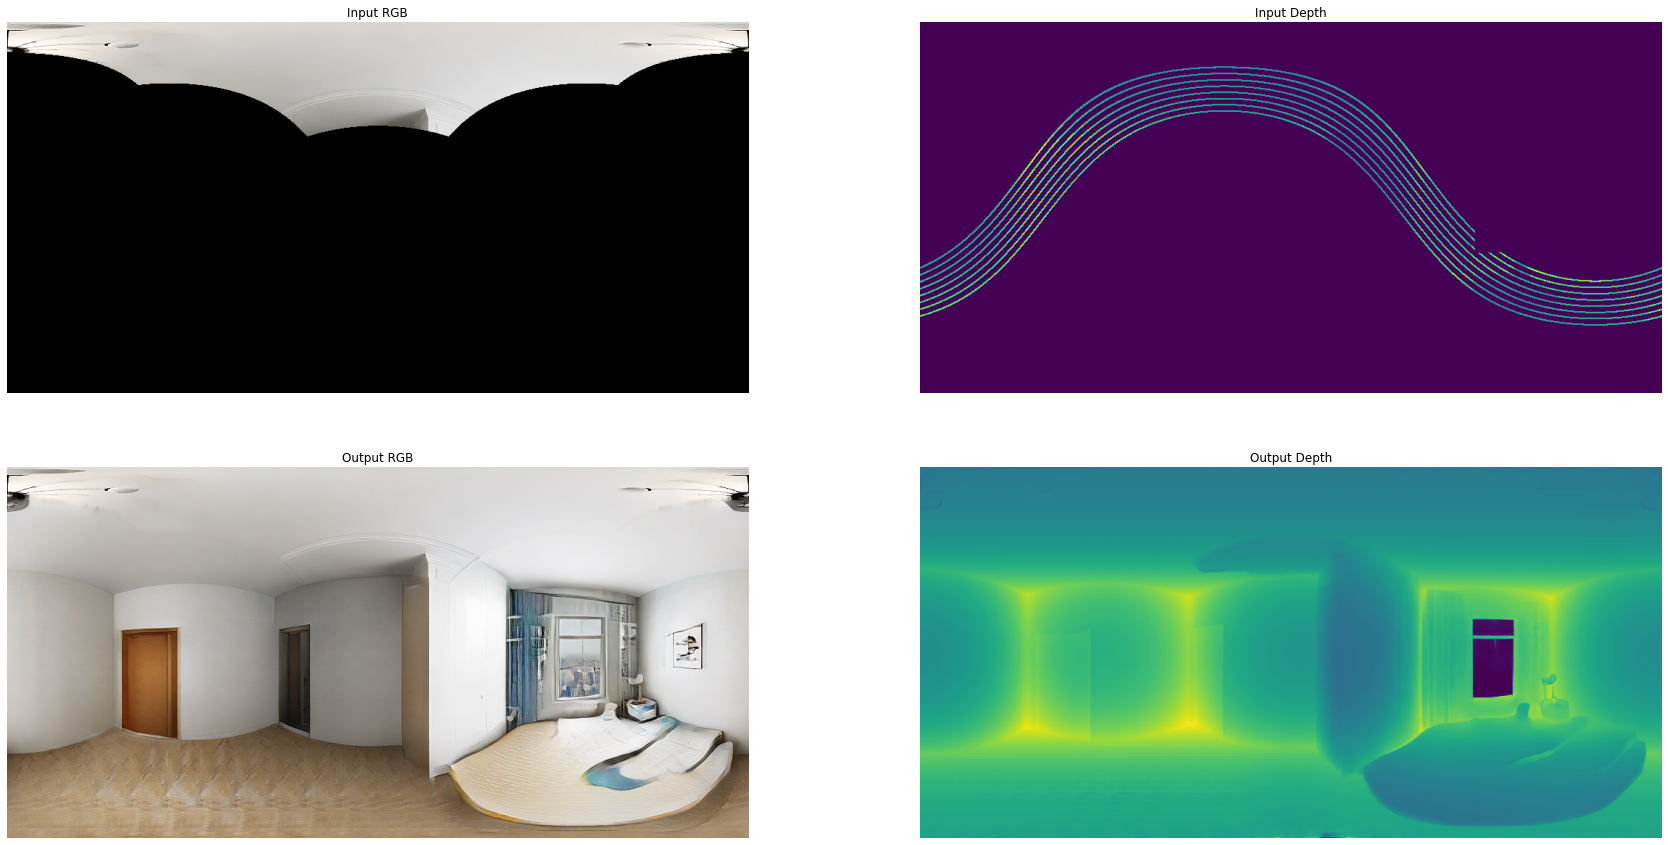

In [ ]:
color_in, depth_in = input[0,:3].permute(1,2,0).detach().cpu(), input[0,-1].detach().cpu()
cmask, dmask = input_mask[0,0].detach().cpu().bool(), input_mask[0,-1].detach().cpu().bool()

out_rgb, out_d = output[0,:3].permute(1,2,0).detach().cpu(), output[0,-1].detach().cpu()

total = cmask.shape[0] * cmask.shape[1]
cmask_ratio = cmask.sum().item()/total*100
dmask_ratio = dmask.sum().item()/total*100
print(f'RGB mask ratio: {cmask_ratio:.2f}%, Depth mask ratio: {dmask_ratio:.2f}%')

color_in = np.array(255*(color_in+1)/2).astype(np.uint8)
inr = color_in.copy()
inr[~cmask] = 0

depth_in = np.array((((2**16-1)*depth_in.detach().cpu()/config.scale_d))).astype(np.uint16)

ind = depth_in.copy()
ind[~dmask] = 0

out_rgb = np.array((out_rgb+1)/2)
out_d = np.array((((2**16-1)*out_d/config.scale_d))).astype(np.uint16)



plt.figure(figsize=(30,15))
ax1 = plt.subplot(2,2,1)
ax1.set_title('Input RGB')
ax1.imshow(inr)
ax1.axis('off')

ax2 = plt.subplot(2,2,2)
ax2.set_title('Input Depth')
ax2.imshow(ind)
ax2.axis('off')

ax3 = plt.subplot(2,2,3)
ax3.set_title('Output RGB')
ax3.imshow(out_rgb)
ax3.axis('off')

ax4 = plt.subplot(2,2,4)
ax4.set_title('Output Depth')
ax4.imshow(out_d)
ax4.axis('off')

plt.show()
plt.close()

In [ ]:
visualize(color_in, depth_in, 20000, mask=cmask)
visualize(color_in, depth_in, 20000, mask=dmask)

visualize(out_rgb, out_d, 20000)


## 9) 모델 테스트 - 저장된 latent 로부터 FAED score 계산

In [ ]:
real_path  = '/content/drive/MyDrive/KCVS/TA_session/stats/gt.npz'
syn_path  = '/content/drive/MyDrive/KCVS/TA_session/stats/ours.npz'

real_data = np.load(real_path)
real_mean = real_data['mean']
real_cov = real_data['cov']

syn_data = np.load(syn_path)
syn_mean = syn_data['mean']
syn_cov = syn_data['cov']

print('[INFO] calculating Frechet distance.')
mu1 = torch.tensor(real_mean).unsqueeze(0)
mu2 = torch.tensor(syn_mean).unsqueeze(0)
sigma1 = torch.tensor(real_cov).unsqueeze(0)
sigma2 = torch.tensor(syn_cov).unsqueeze(0)

fid_score = calculate_Frechet_distance(mu1,sigma1,mu2,sigma2)
print(f'[INFO] Frechet distance is: {fid_score}.')

[INFO] calculating Frechet distance.


NameError: ignored